<a href="https://colab.research.google.com/github/Zamoca42/TIL/blob/main/AI/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 최종프로젝트 설명

자신의 얼굴 인식하는 인공신경망 만들기

1. 자신의 얼굴사진과 타인 1명 얼굴사진을 10장 이상 수집

2. 본인이 정한 크기로 얼굴이 잘 나오게 크롭 혹은 resizing (192 * 144).  
(Train dataset과 Label dataset으로 python에서 읽기)

3. 수업시간에 배운 CNN을 제작 후, input_shape 등을 잘 맞춰서 학습시키기

4. 학습되지 않은 새로운 사진을 가지고 테스트

- 이미지 전처리
  - https://www.tensorflow.org/tutorials/load_data/images
  - https://keras.io/api/data_loading/image/#load_img-function
- 이미지 어그멘테이션
  - https://www.tensorflow.org/tutorials/images/data_augmentation


In [111]:
import numpy as np
import os
import tensorflow as tf
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 기본 경로
base_dir = '/content/drive/MyDrive/ProjectPhoto/'

train_dir = os.path.join(base_dir, 'train')

/content/drive/MyDrive/ProjectPhoto/train/cele
/content/drive/MyDrive/ProjectPhoto/train/me
['29.jpeg', '3.jpeg', '25.jpeg', '12.jpeg', '18.jpeg', '9.jpeg', '15.jpeg', '23.jpeg', '14.jpeg', '28.jpeg']
['20.jpeg', '28.JPG', '1.jpeg', '11.jpeg', '10.jpeg', '26.jpeg', '27.jpeg', '2.jpeg', '25.jpeg', '3.jpeg']


In [112]:
# 이미지 전처리하기
# 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

batch_size = 57
img_height = 192
img_width = 144


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed = 50,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed = 50,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 57 files belonging to 2 classes.
Using 46 files for training.
Found 57 files belonging to 2 classes.
Using 11 files for validation.


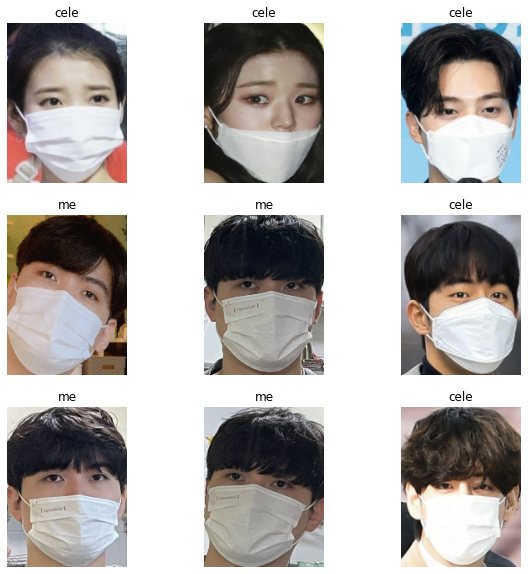

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [114]:
class_names = train_ds.class_names
print(class_names)

['cele', 'me']


In [115]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(46, 192, 144, 3)
(46,)


In [116]:
# 성능을 높이도록 데이터세트 구성

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [117]:
# 데이터 표준화하기

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [118]:
# 모델 훈련하기

num_classes = 2

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'), # input_shape=(192, 144, 3)
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    # Flatten
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [119]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    verbose=2)

Epoch 1/10
1/1 - 1s - loss: 0.6888 - accuracy: 0.5217 - val_loss: 0.7251 - val_accuracy: 0.3636 - 639ms/epoch - 639ms/step
Epoch 2/10
1/1 - 0s - loss: 0.5913 - accuracy: 0.5217 - val_loss: 0.9954 - val_accuracy: 0.6364 - 46ms/epoch - 46ms/step
Epoch 3/10
1/1 - 0s - loss: 1.2121 - accuracy: 0.5217 - val_loss: 0.4866 - val_accuracy: 0.7273 - 45ms/epoch - 45ms/step
Epoch 4/10
1/1 - 0s - loss: 0.4807 - accuracy: 0.7609 - val_loss: 0.7789 - val_accuracy: 0.3636 - 44ms/epoch - 44ms/step
Epoch 5/10
1/1 - 0s - loss: 0.5741 - accuracy: 0.5217 - val_loss: 0.7532 - val_accuracy: 0.3636 - 45ms/epoch - 45ms/step
Epoch 6/10
1/1 - 0s - loss: 0.5418 - accuracy: 0.6087 - val_loss: 0.5203 - val_accuracy: 0.9091 - 45ms/epoch - 45ms/step
Epoch 7/10
1/1 - 0s - loss: 0.3894 - accuracy: 0.9130 - val_loss: 0.4006 - val_accuracy: 0.9091 - 39ms/epoch - 39ms/step
Epoch 8/10
1/1 - 0s - loss: 0.3441 - accuracy: 1.0000 - val_loss: 0.3841 - val_accuracy: 0.7273 - 37ms/epoch - 37ms/step
Epoch 9/10
1/1 - 0s - loss: 0.

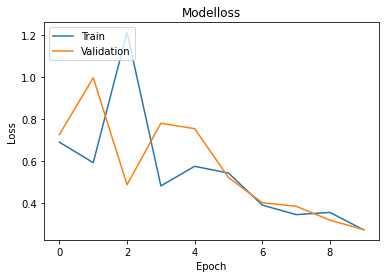

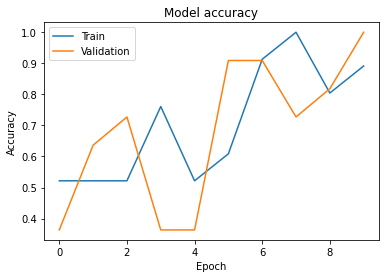

In [120]:
# 플롯

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

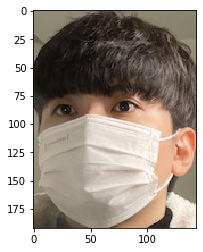

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to me with a 54.98 percent confidence.


In [135]:
test_path = '/content/drive/MyDrive/ProjectPhoto/test.jpeg'

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img, interpolation='nearest')
plt.show()

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

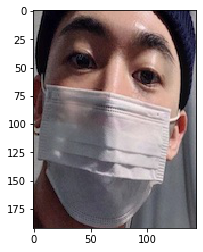

1/1 [==============================] - 0s 26ms/step
This image most likely belongs to cele with a 60.57 percent confidence.


In [137]:
test_path = '/content/drive/MyDrive/ProjectPhoto/test2.jpg'

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img, interpolation='nearest')
plt.show()

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [138]:
print(score)

tf.Tensor([0.60569173 0.39430827], shape=(2,), dtype=float32)


In [139]:
# 모델 저장
model.save('/content/drive/MyDrive/Project_conv_gpu_ver_1.h5')